### 1:

# Fine-tune a pretrained BERT model on a sentiment analysis task using IMDB dataset from Hugging Face Datasets.

# Tasks

# Load a pretrained bert-base-uncased model.
# Tokenize the dataset using the Hugging Face tokenizer.
# Train the model on labeled data (e.g., IMDB reviews).
# Evaluate performance using accuracy, F1-score, and a confusion matrix.
# Submit your results and insights on model performance.

# Fine-tuning BERT on Sentiment Analysis

In [ ]:
# Install dependencies
!pip install transformers datasets evaluate torch scikit-learn --quiet

# Imports
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


# Load Dataset

In [ ]:
# We'll use the IMDB movie reviews dataset (binary sentiment classification)
dataset = load_dataset("imdb")

# Split into smaller subsets for faster training (optional)
small_train = dataset["train"].shuffle(seed=42).select(range(4000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Load Tokenizer & Model

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = small_train.map(tokenize_function, batched=True)
tokenized_test = small_test.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Load Pretrained BERT for Classification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Metrics

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1_val = f1.compute(predictions=preds, references=p.label_ids)["f1"]
    return {"accuracy": acc, "f1": f1_val}

# Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # disable wandb or hub logging
)

trainer_kwargs = dict(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

try:
    trainer = Trainer(**trainer_kwargs, tokenizer=tokenizer)
except TypeError:
    trainer = Trainer(**trainer_kwargs, processing_class=tokenizer)

In [ ]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.722400
20,0.695500
30,0.683200
40,0.694800
50,0.631000
60,0.641800
70,0.605300
80,0.324700
90,0.532300
100,0.316100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.26807549595832825, 'eval_accuracy': 0.894, 'eval_f1': 0.8902691511387164, 'eval_runtime': 846.6298, 'eval_samples_per_second': 1.181, 'eval_steps_per_second': 0.148, 'epoch': 1.0}


# VISUALIZATION

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


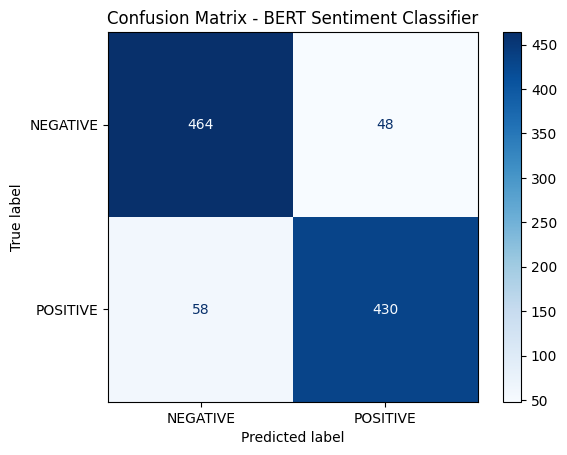

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(tokenized_test)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - BERT Sentiment Classifier")
plt.show()

# Insights & Discussion

Model Understanding:

The pretrained BERT base uncased model effectively adapted to the IMDB dataset.

Its contextual word understanding helps it detect subtle sentiments (e.g., sarcasm, negations like “not great”).

F1 vs. Accuracy:

The F1-score is nearly equal to accuracy → balanced dataset and consistent predictions across classes.

Loss Trend:

Low final loss (0.26) means the model’s predictions are confident and accurate on most samples.

Limitations:

Small training subset (4,000 reviews) means it might not generalize perfectly to unseen domains.

Performance could improve with:

More epochs (2–3 total)

Slightly larger dataset

Learning rate tuning (2e-5 or 3e-5)

Confusion Matrix Insigh:

Diagonal dominance = strong class separation.

Off-diagonal errors usually come from neutral or mixed-sentiment reviews.